In [1]:
import jax
import jax.numpy as jnp
import optax  # https://github.com/deepmind/optax
import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping
import functools as ft

import equinox as eqx

In [2]:
# Hyperparameters

BATCH_SIZE = 64
LEARNING_RATE = 3e-4
EPOCHS = 20
PRINT_EVERY = 3
SEED = 5678

key = jax.random.PRNGKey(SEED)

In [3]:
normalise_data = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
    ]
)

train_dataset = torchvision.datasets.EMNIST(
    '/tmp/emnist/',
    split="balanced",
    train=True,
    download=True,
    transform=normalise_data,
)
test_dataset = torchvision.datasets.EMNIST(
    '/tmp/emnist/',
    split="balanced",
    train=False,
    download=True,
    transform=normalise_data,
)
trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True
)

In [4]:
#checking data
dummy_x, dummy_y = next(iter(trainloader))
dummy_x = dummy_x.numpy()
dummy_y = dummy_y.numpy()
print(dummy_x.shape)  # 64x1x28x28
print(dummy_y.shape)  # 64
print(dummy_y)

(64, 1, 28, 28)
(64,)
[ 9 37 36  4 21 27 14 38 43 45 22 26  6 33 39 38 31 10 42 22  5 43 38 21
  5 15 23 32  6 42 36  3 33 31 24 25  2 41 18 37 43 39  4 31 11 30 15 32
  1 22 22  8 10  6 34 13 44 11 37 36 33  4 29 21]


In [5]:
class CNN(eqx.Module):
    layers: list

    def __init__(self, key):
        keys = jax.random.split(key,4)

        self. layers = [
            eqx.nn.Conv2d(1,3, kernel_size=4, key=keys[0]),
            eqx.nn.MaxPool2d(kernel_size=2),
            jax.nn.relu,
            jnp.ravel,
            eqx.nn.Linear(1728, 512, key=keys[1]),
            jax.nn.sigmoid,#relu?
            eqx.nn.Linear(512,64, key=keys[2]),
            jax.nn.relu,
            eqx.nn.Linear(64,47, key=keys[3]),
            jax.nn.log_softmax,
        ]

    def __call__(self, x: Float[Array, "1 28 28"]) -> Float[Array, "10"]:
        for layer in self.layers:
            x = layer(x)
        return x
    
key, subkey = jax.random.split(key, 2)
model = CNN(subkey)

In [6]:
@jax.jit
def cross_entropy(
    y: Int[Array, "batch"], pred_y: Float[Array, "batch 10"]
) -> Float[Array, ""]:
    #y are labels  and pred_y is our models prediction
    pred_y = jnp.take_along_axis(pred_y, jnp.expand_dims(y, 1), axis=1)
    return -jnp.mean(pred_y)


@eqx.filter_jit
def loss(
    model: CNN, x: Float[Array, "batch 1 28 28"], y: Int[Array, " batch"]
) -> Float[Array, ""]:
    #Input of (BATCH_SIZE, 1, 28, 28) we use vmap over the batch axis 
    pred_y = jax.vmap(model)(x)
    return cross_entropy(y, pred_y)


# Example loss
loss_value = loss(model, dummy_x, dummy_y)
print(loss_value.shape)  # scalar loss
# Example inference
output = jax.vmap(model)(dummy_x)
print(output.shape)  # batch of predictions

()
(64, 47)


In [7]:
value, grads = eqx.filter_value_and_grad(loss)(model, dummy_x, dummy_y)
print(value)

3.8543496


In [8]:
@eqx.filter_jit
def compute_accuracy(
    model: CNN, x: Float[Array, "batch 1 28 28"], y: Int[Array, " batch"]
) -> Float[Array, ""]:
    #Takezs inpt and the current model and computes average accuracy on batch
    pred_y = jax.vmap(model)(x)
    pred_y = jnp.argmax(pred_y, axis=1)
    return jnp.mean(y == pred_y)

In [9]:
def eval(
        model: CNN, testloader: torch.utils.data.DataLoader
):
    avg_loss = 0
    avg_acc = 0
    for x, y in testloader:
        x = x.numpy()
        y = y.numpy()
        #operations in these functions are jit'd so they are fast
        avg_loss += loss(model, x, y)
        avg_acc += compute_accuracy(model, x, y)

    return avg_loss / len(testloader), avg_acc / len(testloader)

In [10]:
eval(model, testloader)

(Array(3.8580563, dtype=float32), Array(0.02127622, dtype=float32))

In [11]:
optim = optax.adamw(LEARNING_RATE)

In [12]:
def train(
        model: CNN,
        trainloader: torch.utils.data.DataLoader,
        testloader: torch.utils.data.DataLoader,
        optim: optax.GradientTransformation,
        steps: int,
        print_every: int,
) -> CNN:
    #filter arrays from non-updatable model layers
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(
        model: CNN,
        opt_state: PyTree,
        x: Float[Array, "batch 1 28 28"],
        y: Int[Array, " batch"],
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value
    
    def infinite_trainloader():
        while True:
            yield from trainloader
    for epoch in range(steps):
        for (x, y) in  trainloader:
            x = x.numpy()
            y = y.numpy()

            model, opt_state, train_loss = make_step(model, opt_state, x, y)
        if (epoch % print_every) == 0 or (steps == steps - 1):
            test_loss, test_accuracy = eval(model, testloader)
            print(
                f"{epoch}=, train_loss={train_loss.item()}, "
                f"test_loss={test_loss.item()}, test_accuracy={test_accuracy.item()}"
            )
    return model

In [13]:
model = train(model, trainloader, testloader, optim, EPOCHS, PRINT_EVERY)

0=, train_loss=0.6176803708076477, test_loss=0.9373813271522522, test_accuracy=0.7220805287361145
3=, train_loss=0.39206814765930176, test_loss=0.5857856869697571, test_accuracy=0.8142006397247314
6=, train_loss=0.7959734201431274, test_loss=0.5188784599304199, test_accuracy=0.8302153944969177
9=, train_loss=0.4948487877845764, test_loss=0.484325110912323, test_accuracy=0.8411812782287598
12=, train_loss=0.7226671576499939, test_loss=0.4782400131225586, test_accuracy=0.8408269286155701
15=, train_loss=0.2686757445335388, test_loss=0.49602413177490234, test_accuracy=0.8379747271537781
18=, train_loss=0.1795247495174408, test_loss=0.46937382221221924, test_accuracy=0.8453798294067383


label 3, prediction 3
label 30, prediction 30
label 23, prediction 23
label 29, prediction 29
label 18, prediction 18
label 4, prediction 4
label 18, prediction 15
label 8, prediction 8
label 8, prediction 8
label 26, prediction 0
label 23, prediction 23
label 10, prediction 10
label 43, prediction 23
label 33, prediction 33
label 2, prediction 2
label 24, prediction 0
label 12, prediction 12
label 0, prediction 24
label 31, prediction 31
label 41, prediction 41


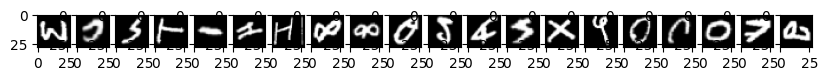

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,7))
rows = 1
columns= 20

for i in range(20):
    fig.add_subplot(rows,columns,i+1)
    img_index = i
    images, labels = next(iter(trainloader))
    preds = model(images[img_index].numpy())
    plt.imshow(images[img_index].reshape(28,28), cmap='gray')
    print(f"label {labels[img_index]}, prediction {jnp.argmax(preds)}")